# Part 2 - Building and Training Models

In this notebook we will cover the following topics

* Creating models from scratch with Keras
* Training the model
* Looking at the results of the training


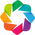

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')  # Hide np.floating warning
import holoviews as hv
hv.extension('bokeh')

In [2]:
# Prevent TensorFlow from grabbing all the GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Loading Data

Using the pattern we saw in the last notebook, we can load and transform the CIFAR10 data for deep learning.

In [3]:
from keras.datasets import cifar10
import keras.utils

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Save an unmodified copy of y_test for later, flattened to one column
y_test_true = y_test[:,0].copy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The data only has numeric categories so we also have the string labels below 
cifar10_labels = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 
                           'dog', 'frog', 'horse', 'ship', 'truck'])

Using TensorFlow backend.


## Creating a Model

The simplest way to define a deep learning model in Keras is using the [Sequential class](https://keras.io/getting-started/sequential-model-guide/), which holds a stack of layers that are executed in sequence.

Keras has an [extensive catalog of layers](https://keras.io/layers/about-keras-layers/), making it very easy to recreate almost any network you find in the literature.  The VGG16-like networks we will use in this tutorial have the following kinds of layers:
* Conv2D - 2D convolutions, useful for image networks
* MaxPooling2D - Pooling of adjacent values using the `max()` function in 2 dimensions, also useful in image networks
* Flatten - Turn any shape input in to a flat, 1D output.  Often used to transition to dense layers
* Dense - The traditional neural network layer, where each output is a weighted sum of input layers + offset with an activation function.

Keras also has a large list of supported [activation functions](https://keras.io/activations/).  For all of these examples, we will use the `relu` function as it has good performance.

We begin by importing the necessary classes:

In [4]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Creating a Keras model has the following structure:

* Create empty model
* Add layers in order, setting the input_shape for the first layer
* Finish by compiling the model with a loss function, an optimizer, and a list of metrics to compute during fitting

The choice of [loss function](https://keras.io/losses/) depends on the kind of model we are training.  Since we are doing categorization with more than two categories, `categorical_crossentropy` is preferred.

The choice of [optimizer](https://keras.io/optimizers/) is less straightforward.  We're using `Adadelta` because it is self-tuning and works pretty well on this problem.

Metrics are functions that score your model, but are not used to optimize it.  The most common metric is accuracy, so we include it here.

In [5]:
model = Sequential()

### Convolution and max pool layers

# Group 1: Convolution
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Group 2: Convolution
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Group 3: Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

We can inspect various properties of the model, such as the number of free parameters:

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

Here we see that the majority of free parameters are introduced at the point where we switch from the convolutional layers to the dense layers.  If we want to reduce the size of this model, we will either need to reduce the size of the dense layer or reduce the number of convolution kernels.

## Training a Model

To train a model, we use the `fit()` method on a compiled model:

In [7]:
%%time
history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 80us/step - loss: 2.0435 - acc: 0.2570 - val_loss: 1.8716 - val_acc: 0.3236
Epoch 2/5
50000/50000 [==============================] - 3s 57us/step - loss: 1.5952 - acc: 0.4305 - val_loss: 1.6920 - val_acc: 0.3997
Epoch 3/5
50000/50000 [==============================] - 3s 57us/step - loss: 1.3836 - acc: 0.5087 - val_loss: 1.3540 - val_acc: 0.5211
Epoch 4/5
50000/50000 [==============================] - 3s 57us/step - loss: 1.2170 - acc: 0.5697 - val_loss: 1.2389 - val_acc: 0.5695
Epoch 5/5
50000/50000 [==============================] - 3s 57us/step - loss: 1.0959 - acc: 0.6147 - val_loss: 1.2894 - val_acc: 0.5480
CPU times: user 17 s, sys: 1.37 s, total: 18.4 s
Wall time: 15.7 s


The `epochs` value controls how many passes through the training data are taken.  The `batch_size` determines how many training examples are processed in parallel.  The model parameters are updated between each batch using backpropagation according to the optimizer's strategy.  Batch size affects both training performance and model quality, as we'll discuss later.

The validation data is not used by the optimizer for training, but it is scored between each epoch to give an independent assessment of the model quality.  The results for the validation data are what you should keep an eye on to understand how well the model is generalizing.  In the next notebook, we'll look more closely at how to interpret differences in accuracy between training and validation data.

Note that the model object retains its state after training.  If we wanted additional rounds of training, we could call `fit()` again, and it would pick up where the last fit left off:

In [8]:
model.fit(x_train, y_train,
          batch_size=256,
          epochs=2,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 3s 58us/step - loss: 0.9834 - acc: 0.6556 - val_loss: 1.0391 - val_acc: 0.6408
Epoch 2/2
50000/50000 [==============================] - 3s 58us/step - loss: 0.8845 - acc: 0.6923 - val_loss: 1.0083 - val_acc: 0.6401


One of the more powerful features of the `fit()` method is the `callbacks` argument.  We can use [prebuilt classes](https://keras.io/callbacks/), or create our own, that are called after every batch and epoch to update status or cause the fit to terminate.  For example, we can use the [EarlyStopping](https://keras.io/callbacks/#earlystopping) to end the fit if no improvement larger than 5% is seen for 2 training epochs

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.05, patience=2, verbose=1)
model.fit(x_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stop])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.7969 - acc: 0.7216 - val_loss: 1.0698 - val_acc: 0.6278
Epoch 2/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.7258 - acc: 0.7494 - val_loss: 1.1448 - val_acc: 0.6253
Epoch 3/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.6616 - acc: 0.7686 - val_loss: 0.9654 - val_acc: 0.6822
Epoch 4/10
50000/50000 [==============================] - 3s 57us/step - loss: 0.6033 - acc: 0.7907 - val_loss: 1.0658 - val_acc: 0.6475
Epoch 5/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.5463 - acc: 0.8108 - val_loss: 1.0214 - val_acc: 0.6688
Epoch 00005: early stopping


## Inspecting the Fit

Now that the model is trained, we can use the model object in various ways.  First, we can look at the training history object:

In [10]:
print(history.epoch)
history.history

[0, 1, 2, 3, 4]


{'acc': [0.25704, 0.4305, 0.5086599999809265, 0.569699999961853, 0.6147],
 'loss': [2.0435095067596434,
  1.595242286338806,
  1.3835743425369262,
  1.2170331132125856,
  1.0959398950004577],
 'val_acc': [0.3236, 0.3997, 0.5211, 0.5695, 0.548],
 'val_loss': [1.8716150005340577,
  1.691998955154419,
  1.3539836660385132,
  1.2388545431137086,
  1.2893842281341552]}

The `history.history` dictionary has tracked several different values through the training process:

* `acc`: Accuracy of the model on the training set, averaged over the batches
* `val_acc`: Accuracy of the model on the validation set
* `loss`: Value of the loss function on the training set, averaged over the batches
* `val_loss`: Value of the loss function on the validation set

Note that the loss function on the training data is the only thing the optimizer is trying to minimize.  The other metrics hopefully improve at the same time, but do not always.

We can plot the accuracy on the test and training data with Holoviews:

In [11]:
%%opts Curve [width=400 height=300]
%%opts Curve (line_width=3)
%%opts Overlay [legend_position='top_left']

train_acc = hv.Curve((history.epoch, history.history['acc']), 'epoch', 'accuracy', label='training')
val_acc = hv.Curve((history.epoch, history.history['val_acc']), 'epoch', 'accuracy', label='validation')

train_acc * val_acc

:Overlay
   .Curve.Training   :Curve   [epoch]   (accuracy)
   .Curve.Validation :Curve   [epoch]   (accuracy)

We can also look individual predictions.  Let's run the final trained model over the validation set:

In [12]:
y_predict = model.predict(x_test)
y_predict[:5]

array([[1.51808886e-03, 2.37888210e-02, 7.16965878e-03, 3.72798920e-01,
        6.74304413e-03, 5.48944890e-01, 1.70324362e-04, 3.39415669e-02,
        4.87173302e-03, 5.30002035e-05],
       [1.14607301e-05, 7.31542648e-04, 1.43222170e-10, 8.67746208e-10,
        1.17984433e-11, 3.03656683e-11, 9.89228578e-12, 9.20424327e-13,
        9.99037266e-01, 2.19731679e-04],
       [1.87350847e-02, 3.46547574e-01, 1.51950773e-03, 2.43605129e-04,
        1.53060464e-05, 1.88112899e-05, 4.49043546e-06, 2.26566161e-04,
        5.65996408e-01, 6.66926578e-02],
       [7.37982810e-01, 2.31588781e-01, 5.49640367e-03, 4.46284597e-04,
        4.87245823e-04, 2.09995473e-04, 1.01032216e-04, 1.45938844e-04,
        1.69953108e-02, 6.54619141e-03],
       [1.88789145e-05, 1.67287348e-04, 3.48535622e-03, 9.73150432e-02,
        7.88085759e-01, 6.50624707e-02, 4.47535180e-02, 5.65006630e-04,
        1.50703621e-04, 3.96000105e-04]], dtype=float32)

This is still using the one-hot encoding, where each input image produces 10 columns (for categories 0-9) of output.  Normally, we would take the column with the largest output as the predicted category.  We could do this with some NumPy magic, but Keras also includes a convenience method `predict_classes()`, which does this automatically:

In [13]:
y_predict = model.predict_classes(x_test)
y_predict[:5]

array([5, 8, 8, 0, 4])

And then we can use our label array and NumPy fancy indexing to see these as strings:

In [14]:
y_predict_labels = cifar10_labels[y_predict]
y_true_labels = cifar10_labels[y_test_true]
print(y_predict_labels[:5])
print(y_true_labels[:5])

['dog' 'ship' 'ship' 'airplane' 'deer']
['cat' 'ship' 'ship' 'airplane' 'frog']


Holoviews makes it easy to look at the first few predictions:

In [15]:
%%output size=64
%%opts RGB [xaxis=None yaxis=None]

images = [hv.RGB(x_test[i], label='%s(%s)' % (y_true_labels[i], y_predict_labels[i]) ) for i in range(12)]
hv.Layout(images).cols(4)

:Layout
   .RGB.Cat_left_parenthesis_dog_right_parenthesis.I             :RGB   [x,y]   (R,G,B)
   .RGB.Ship_left_parenthesis_ship_right_parenthesis.I           :RGB   [x,y]   (R,G,B)
   .RGB.Ship_left_parenthesis_ship_right_parenthesis.II          :RGB   [x,y]   (R,G,B)
   .RGB.Airplane_left_parenthesis_airplane_right_parenthesis.I   :RGB   [x,y]   (R,G,B)
   .RGB.Frog_left_parenthesis_deer_right_parenthesis             :RGB   [x,y]   (R,G,B)
   .RGB.Frog_left_parenthesis_dog_right_parenthesis              :RGB   [x,y]   (R,G,B)
   .RGB.Automobile_left_parenthesis_dog_right_parenthesis        :RGB   [x,y]   (R,G,B)
   .RGB.Frog_left_parenthesis_frog_right_parenthesis             :RGB   [x,y]   (R,G,B)
   .RGB.Cat_left_parenthesis_dog_right_parenthesis.II            :RGB   [x,y]   (R,G,B)
   .RGB.Automobile_left_parenthesis_automobile_right_parenthesis :RGB   [x,y]   (R,G,B)
   .RGB.Airplane_left_parenthesis_airplane_right_parenthesis.II  :RGB   [x,y]   (R,G,B)
   .RGB.Truck_left_parenthesis_truck_right_parenthesis           :RGB   [x,y]   (R,G,B)

In fact, let's select out the failed predictions with more NumPy fancy indexing:

In [16]:
failed = y_predict != y_test_true
print('Number failed:', np.count_nonzero(failed))

Number failed: 3312


In [17]:
%%output size=64
%%opts RGB [xaxis=None yaxis=None]

images = [hv.RGB(x_test[failed][i], label='%s(%s)' % 
                 (y_true_labels[failed][i],
                  y_predict_labels[failed][i]) ) for i in range(12)]
hv.Layout(images).cols(4)

:Layout
   .RGB.Cat_left_parenthesis_dog_right_parenthesis.I        :RGB   [x,y]   (R,G,B)
   .RGB.Frog_left_parenthesis_deer_right_parenthesis        :RGB   [x,y]   (R,G,B)
   .RGB.Frog_left_parenthesis_dog_right_parenthesis.I       :RGB   [x,y]   (R,G,B)
   .RGB.Automobile_left_parenthesis_dog_right_parenthesis   :RGB   [x,y]   (R,G,B)
   .RGB.Cat_left_parenthesis_dog_right_parenthesis.II       :RGB   [x,y]   (R,G,B)
   .RGB.Dog_left_parenthesis_deer_right_parenthesis         :RGB   [x,y]   (R,G,B)
   .RGB.Bird_left_parenthesis_deer_right_parenthesis        :RGB   [x,y]   (R,G,B)
   .RGB.Deer_left_parenthesis_ship_right_parenthesis        :RGB   [x,y]   (R,G,B)
   .RGB.Bird_left_parenthesis_automobile_right_parenthesis  :RGB   [x,y]   (R,G,B)
   .RGB.Deer_left_parenthesis_horse_right_parenthesis       :RGB   [x,y]   (R,G,B)
   .RGB.Automobile_left_parenthesis_truck_right_parenthesis :RGB   [x,y]   (R,G,B)
   .RGB.Frog_left_parenthesis_dog_right_parenthesis.II      :RGB   [x,y]   (R,G,B)

We'll learn more about evaluating the model in the next section.

## Experiments to Try

* Try changing some of the model parameters (number of dense nodes, number of convolution kernels) and see how training changes.
* Try changing the batch size during training to see how the speed of training is affected (and the final accuracy).
* Try changing `relu` to `sigmoid`.

If you screw everything up, you can use File / Revert to Checkpoint to go back to the first version of the notebook and restart the Jupyter kernel with Kernel / Restart.